In [18]:
import torch
from torchvision import transforms
import numpy as np
import pandas as pd
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from positional_encodings.torch_encodings import PositionalEncodingPermute2D, Summer

import os, sys
import itertools

sys.path.append(os.path.join(os.getcwd(), '../..'))

from ml_stuff.metadata_loader import MetadataLoader
from ml_stuff.batch_generator import WaveDataset
from ml_stuff.batch_factory import BatchFactory
from ml_stuff.positional_encoding import SinusoidalPositionalEmbedding
from ml_stuff.resnet_regressor import ResnetRegressor

from tqdm import tqdm, trange
plt.rcParams['figure.dpi'] = 200

In [3]:
asv50_stations = (2763, 2777, 2792, 2809, 2821, 2833, 2841)
stations = tuple((f'/storage/tartar/suslovai/input_nn/input_nn_ASV50/target_ASV50/{i}_target_meteo.csv',
                  f'/storage/tartar/suslovai/input_nn/input_nn_ASV50/radar_data_ASV50/{i}_full_len.npy')
                 for i in asv50_stations)

mdl = MetadataLoader(stations=stations, split=(0.7, 0.15, 0.15))

overall len: 12539
train len: 8772
validation len: 1877
test len: 1883


In [4]:
mdl.all_df

,buoy_datetime,h,wind_speed,radar_datetime,wind_direction,sin_wind_direction,cos_wind_direction,median,npy_index,station,cruise,npy_path,hard_mining_weight,last_predicted
0,2020-08-11 11:30:07.599,1.423883,63.613387,2020-08-11 11:30:07.125,4.191072,0.895816,0.444426,111.248730,88,2763,ASV50,/storage/tartar/suslovai/input_nn/input_nn_ASV...,1.0,NaN
1,2020-08-11 11:30:08.000,1.423514,63.613387,2020-08-11 11:30:07.125,4.191072,0.895816,0.444426,111.248730,88,2763,ASV50,/storage/tartar/suslovai/input_nn/input_nn_ASV...,1.0,NaN
2,2020-08-11 11:30:08.400,1.423043,63.613387,2020-08-11 11:30:09.235,4.191072,0.895816,0.444426,111.248730,89,2763,ASV50,/storage/tartar/suslovai/input_nn/input_nn_ASV...,1.0,NaN
3,2020-08-11 11:30:08.799,1.422471,63.613387,2020-08-11 11:30:09.235,4.191072,0.895816,0.444426,111.248730,89,2763,ASV50,/storage/tartar/suslovai/input_nn/input_nn_ASV...,1.0,NaN
4,2020-08-11 11:30:09.200,1.421793,63.613387,2020-08-11 11:30:09.235,4.191072,0.895816,0.444426,111.248730,89,2763,ASV50,/storage/tartar/suslovai/input_nn/input_nn_ASV...,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12534,2020-08-23 12:48:08.400,1.475997,90.720754,2020-08-23 12:48:08.292,9.366310,0.999921,-0.012579,61.701743,602,2841,ASV50,/storage/tartar/suslovai/input_nn/input_nn_ASV...,1.0,NaN
12535,2020-08-23 12:48:08.799,1.474853,90.720754,2020-08-23 12:48:08.292,9.366310,0.999921,-0.012579,61.701743,602,2841,ASV50,/storage/tartar/suslovai/input_nn/input_nn_ASV...,1.0,NaN
12536,2020-08-23 12:48:09.200,1.473781,90.720754,2020-08-23 12:48:08.292,9.366310,0.999921,-0.012579,61.701743,602,2841,ASV50,/storage/tartar/suslovai/input_nn/input_nn_ASV...,1.0,NaN
12537,2020-08-23 12:48:09.599,1.472787,90.720754,2020-08-23 12:48:10.404,9.366310,0.999921,-0.012579,61.701743,603,2841,ASV50,/storage/tartar/suslovai/input_nn/input_nn_ASV...,1.0,NaN


Text(0.5, 0, 'significant_wave_height, m')

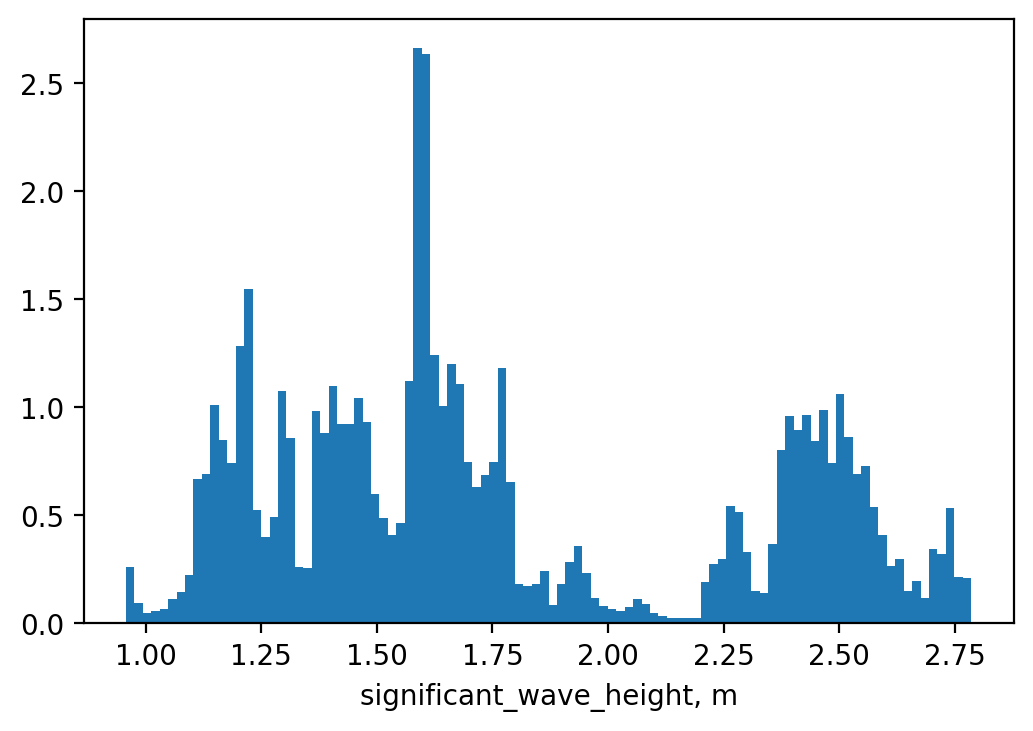

In [4]:
plt.hist(mdl.all_df['h'].tolist(), bins=100, density=True)
plt.xlabel('significant_wave_height, m')

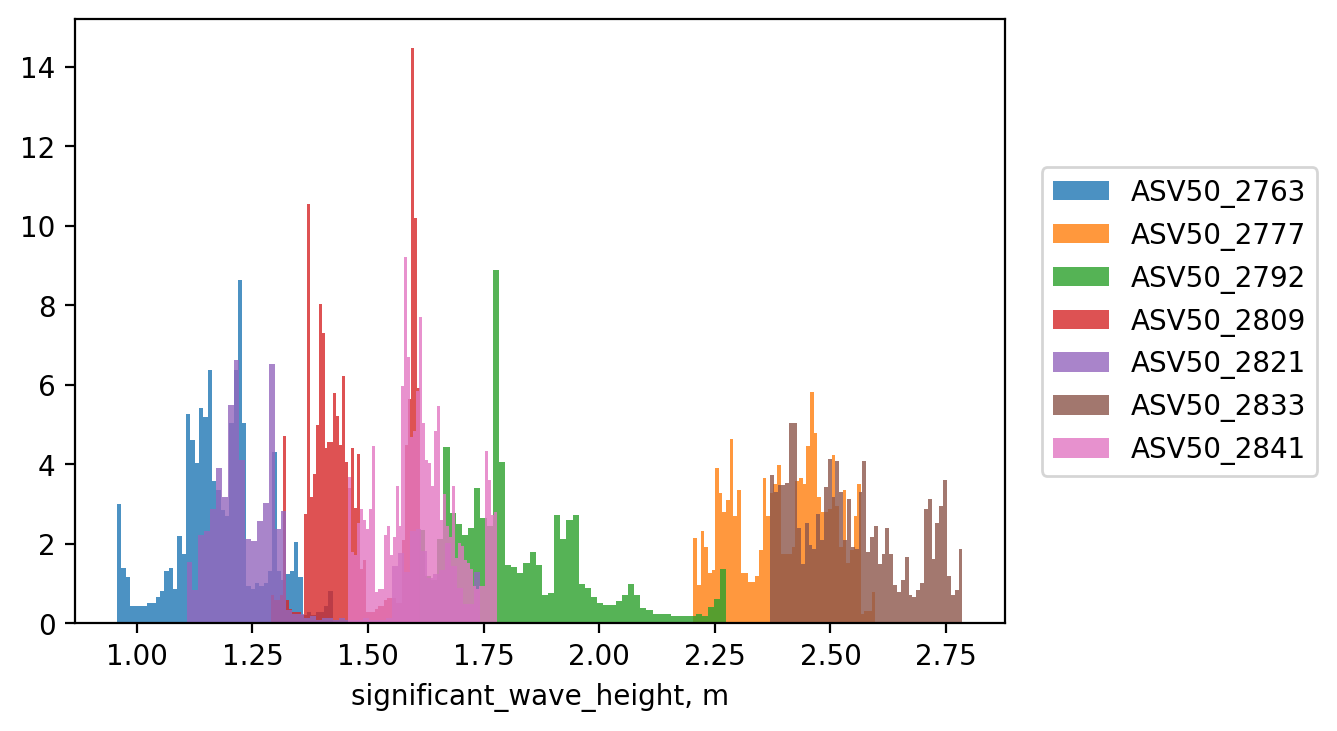

In [5]:
for cruise in mdl.all_df.cruise.unique():
    for station in mdl.all_df.station.unique():
        selection = (mdl.all_df.station == station) & (mdl.all_df.cruise == cruise)
        plt.hist(mdl.all_df[selection].h.tolist(), bins=50, density=True, alpha=0.8, label=f'{cruise}_{station}')

plt.xlabel('significant_wave_height, m')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)

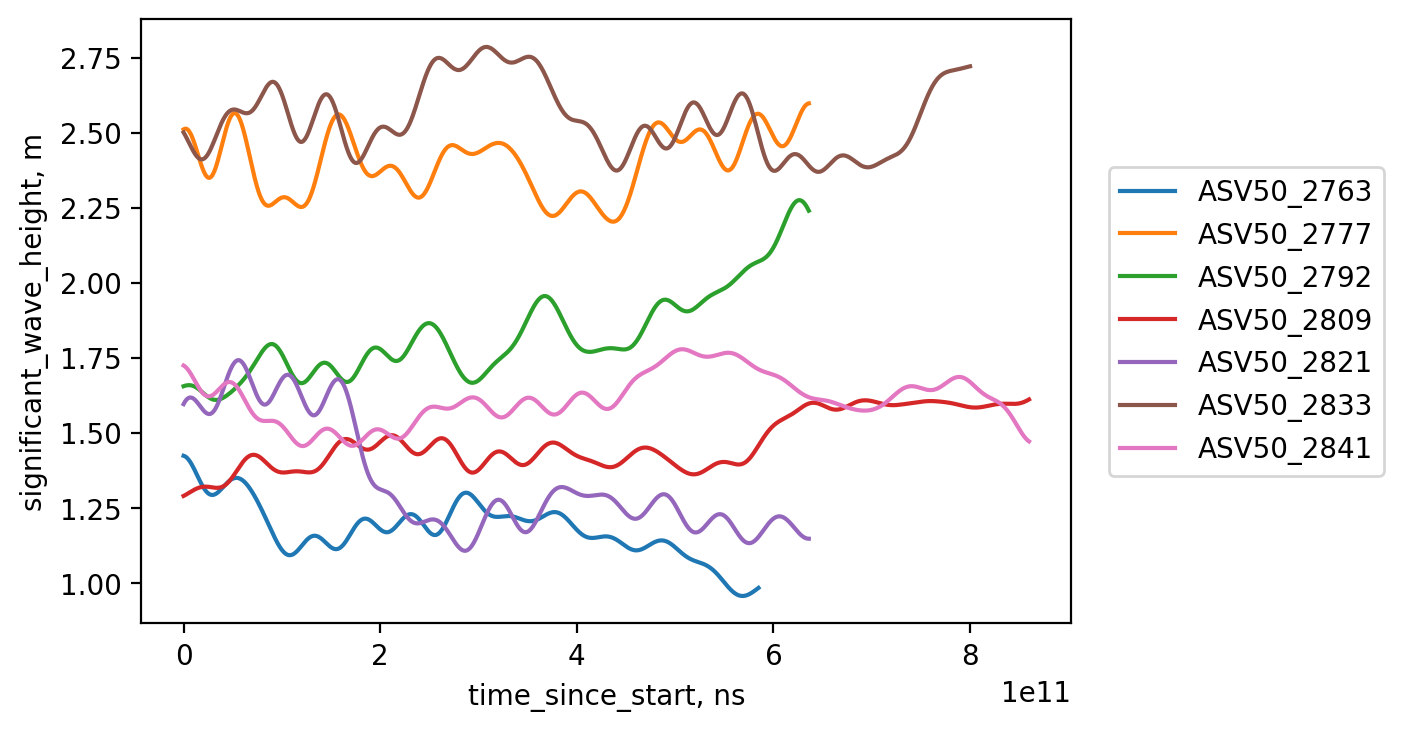

In [6]:
for cruise in mdl.all_df.cruise.unique():
    for station in mdl.all_df.station.unique():
        selection = (mdl.all_df.station == station) & (mdl.all_df.cruise == cruise)
        time_since_start = mdl.all_df[selection].buoy_datetime - mdl.all_df[selection].buoy_datetime.min()
        plt.plot(time_since_start, mdl.all_df[selection].h, label=f'{cruise}_{station}')

plt.xlabel('time_since_start, ns')
plt.ylabel('significant_wave_height, m')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)

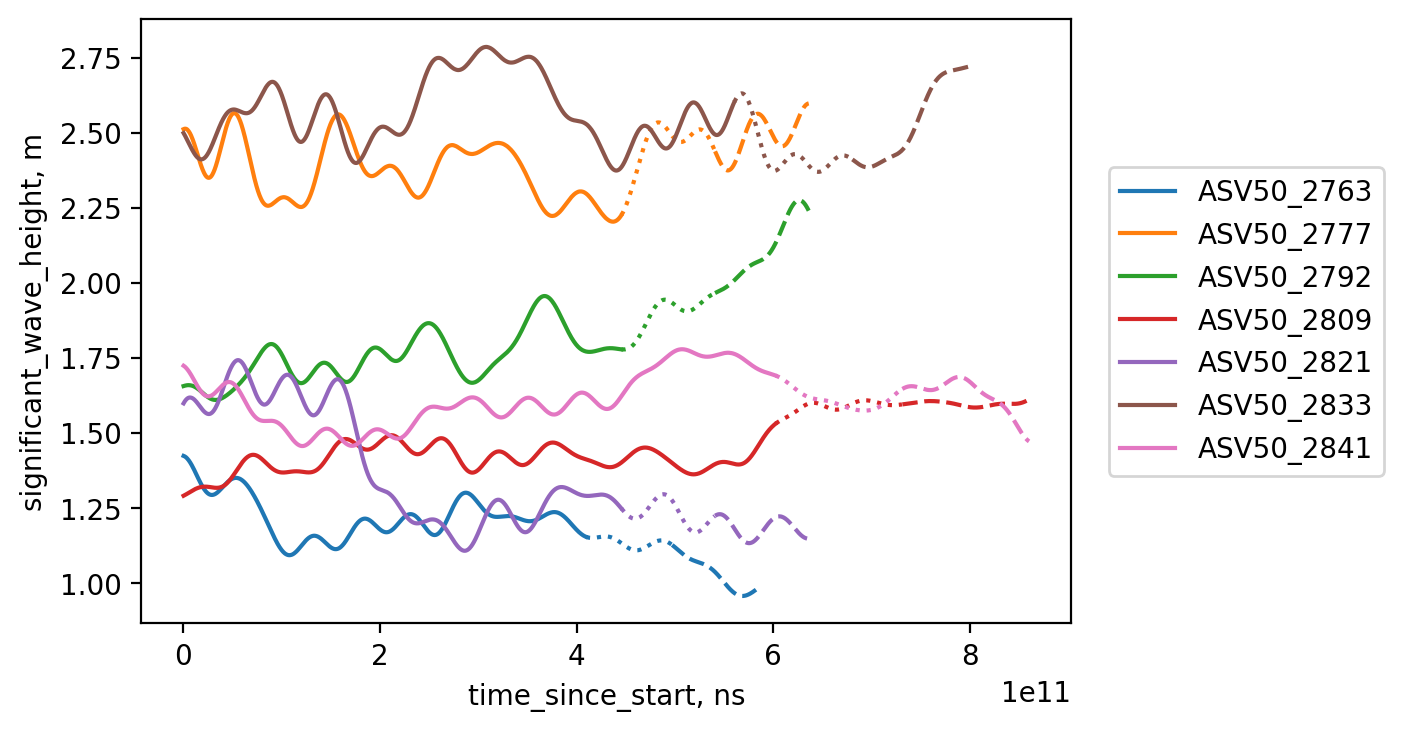

In [7]:
color_iterator = itertools.cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])
styles = ('-', ':', '--')

for cruise in mdl.all_df.cruise.unique():
    for station in mdl.all_df.station.unique():
        time_selection = (mdl.all_df.station == station) & (mdl.all_df.cruise == cruise)
        min_time = mdl.all_df[time_selection].buoy_datetime.min()

        color = color_iterator.__next__()
        
        for df, style in zip((mdl.train, mdl.validation, mdl.test,), styles):
            selection = (df.station == station) & (df.cruise == cruise)
            time_since_start = df[selection].buoy_datetime - min_time
            label = f'{cruise}_{station}' if style == styles[0] else None
            plt.plot(time_since_start, df[selection].h, style, label=label, color=color)

plt.xlabel('time_since_start, ns')
plt.ylabel('significant_wave_height, m')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)


In [8]:
for cruise in mdl.all_df.cruise.unique():
    for station in mdl.all_df.station.unique():
        selection = (mdl.all_df.station == station) & (mdl.all_df.cruise == cruise)
        label = f'{cruise}_{station}'
        print(label, mdl.all_df[selection].h.std())


ASV50_2763 0.09447582054693349
ASV50_2777 0.10249953559086417
ASV50_2792 0.15196117190513253
ASV50_2809 0.09103103709836041
ASV50_2821 0.18987858931102813
ASV50_2833 0.11957314508113252
ASV50_2841 0.08144386740078689


In [9]:
summ = 0
for i in mdl.npy_paths:
    summ += np.load(i, mmap_mode='r').shape[0]
summ

5243

In [10]:
dataset = WaveDataset(mdl.train)

factory = BatchFactory(dataset=dataset, 
             cuda_device='cuda:2', do_augment=True, encoder_dimension=1
            )

In [11]:
batch = factory.cuda_queue.get()

/app/scripts/anikin/venv_39/lib/python3.9/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Mask with shape torch.Size([32, 1, 480, 960]) cached


In [12]:
# factory.stop()

In [13]:
def my_show(batch, slice_, ):
    waves = batch.significant_wave_height[slice_]
    imgs = batch.images[slice_].detach().cpu().numpy()
    fig = plt.figure()
    fig.set_tight_layout(tight={'pad': -0.1,})
    square_size = np.ceil(np.sqrt(imgs.shape[0])).astype(int)
    
    for i in range(imgs.shape[0]):
        ax = fig.add_subplot(square_size, square_size, i + 1)
        ax.imshow(imgs[i, 0, :, :], cmap='Blues_r', 
                  # origin='lower'
                 )
        ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        # ax.text(np.mean(ax.get_xlim()), max(ax.get_ylim()),
        #         f'{waves[i].item():.3f}',
        #         horizontalalignment='center',
        #         verticalalignment='bottom',
        #         backgroundcolor='white'
        #        )

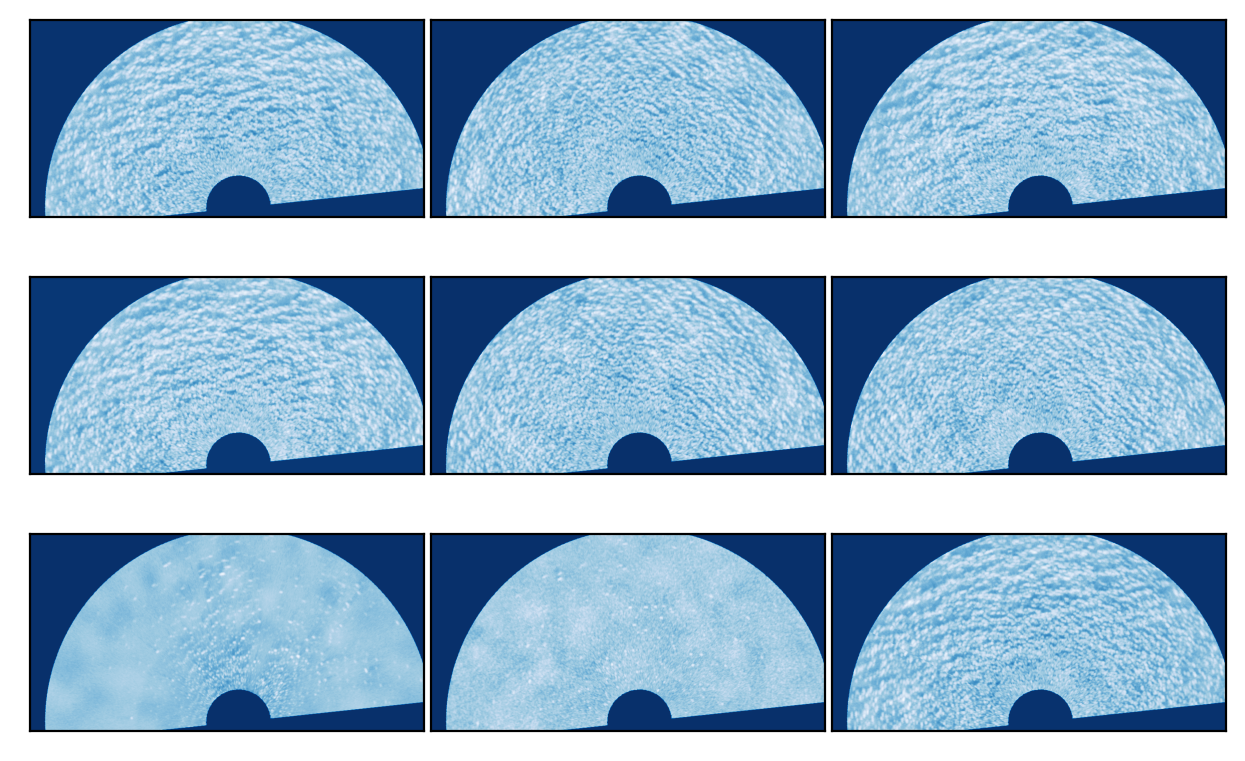

In [14]:
my_show(batch, slice(0, 9, None))

In [15]:
dataset.wave_frame.loc[batch.train_frame_indexes[2]]

buoy_datetime                                2020-08-23 12:41:52.799000
h                                                              1.728516
wind_speed                                                    90.720754
radar_datetime                                  2020-08-23 12:41:53.368
wind_direction                                                  9.36631
sin_wind_direction                                             0.999921
cos_wind_direction                                            -0.012579
median                                                        61.701743
npy_index                                                           423
station                                                            2841
cruise                                                            ASV50
npy_path              /storage/tartar/suslovai/input_nn/input_nn_ASV...
hard_mining_weight                                                  1.0
Name: 8473, dtype: object

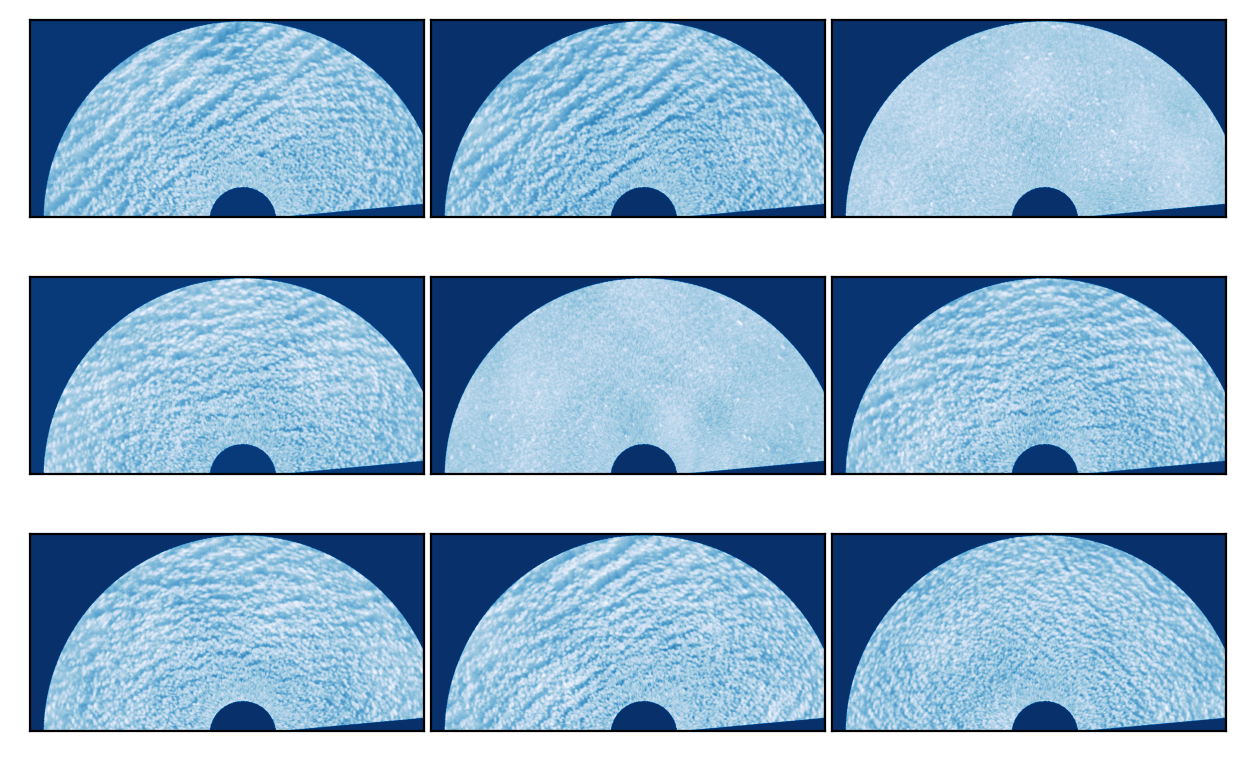

In [16]:
batch = factory.cuda_queue.get()
my_show(batch, slice(None, 9, None))

In [20]:
collector = 0
counter = 0

for i in mdl.npy_paths:
    npy = np.load(i, mmap_mode='r')
    for j in range(npy.shape[0]):
        counter += 1

for i in mdl.npy_paths:
    npy = np.load(i, mmap_mode='r')
    pbar = tqdm(npy.shape[0])
    for j in range(npy.shape[0]):
        collector += npy[j, :, :].mean() / counter
        pbar.set_postfix({'collector': collector, 'max': npy[j, :, :].max()})
        pbar.update()
    pbar.close()
        
print(collector)

169it [00:07, 20.38it/s, collector=4.06, max=255]

KeyboardInterrupt: 

169it [00:19, 20.38it/s, collector=4.06, max=255]

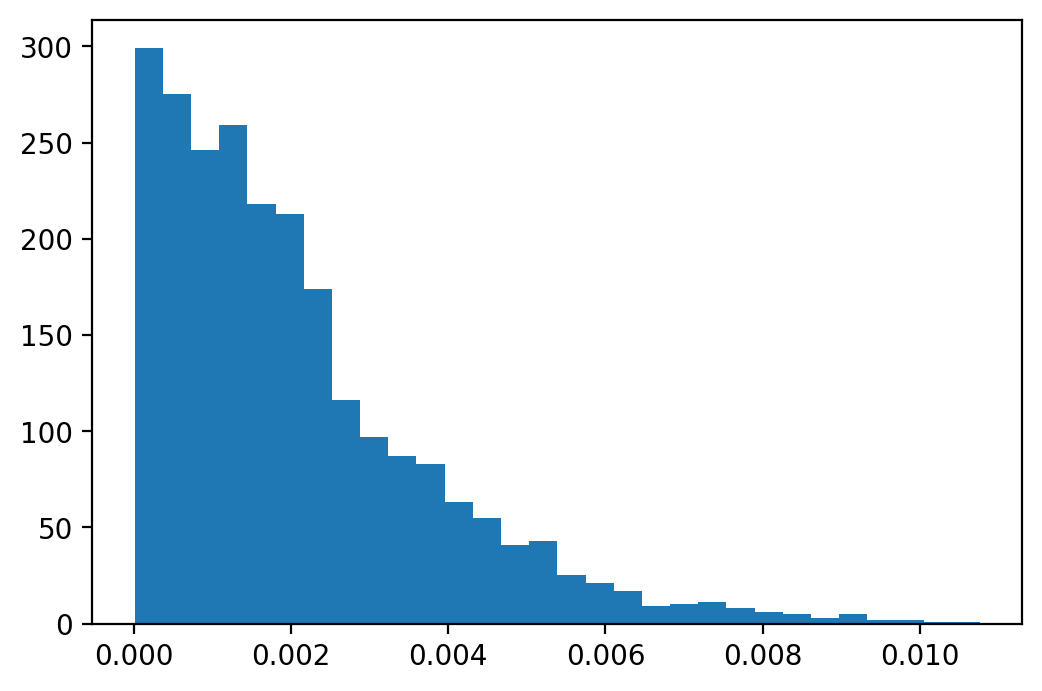

In [16]:
fig, ax = plt.subplots()
stds = [sub_df.h.std() for key, sub_df in mdl.all_df.groupby(['station', 'cruise', 'npy_index'])]
_ = plt.hist(stds, bins=30)

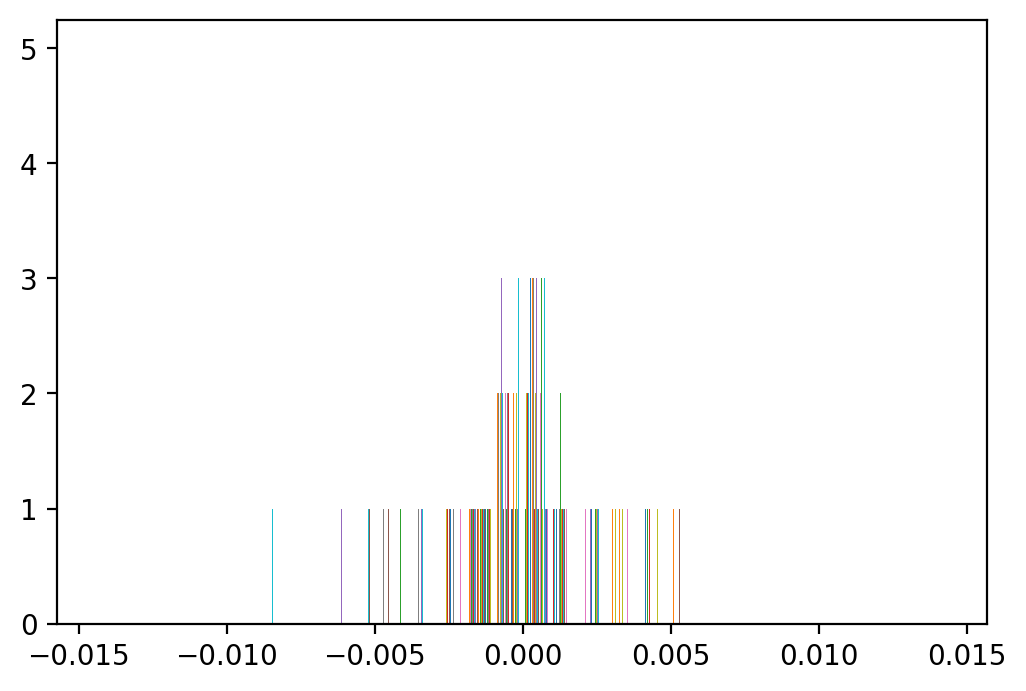

In [17]:
fig, ax = plt.subplots()
stds = [sub_df.h - sub_df.h.mean() for key, sub_df in mdl.all_df.groupby(['station', 'cruise', 'npy_index'])]
_ = plt.hist(stds, bins=30)

In [19]:
ResnetRegressor()

ResnetRegressor(
  (resnet): ResNet(
    (conv1): CoordConv2d(
      (conv): Conv2d(9, 128, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    )
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): CoordConv2d(
          (conv): Conv2d(136, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): CoordConv2d(
          (conv): Conv2d(72, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
        )
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): CoordConv2d(
          (conv): Conv2d(72, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (bn3): BatchNorm2